In [1]:
import glob
import os

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

from generators import ImageGenerator
from utils import plot_accuracy_loss

In [2]:
# set path to data
primary_path = # set the path to the data i.e. '../webvision-2020-public/classification/data/'

In [3]:
# change batch size
# remove sample_frac
training_data = ImageGenerator(primary_path + 'train/',
                               64, (300, 300), sample_frac = 0.01)

# make a validation data generator

Found 147470 instances belonging to 5000 classes


In [4]:
pre_trained_model = InceptionV3(input_shape = (300, 300, 3), 
                                include_top = False)

Note: check how many gpus are available before running `tf.distribute.MirroredStrategy()`

We may need to set the devices to use.

In [5]:
# lock the layers
for layer in pre_trained_model.layers:
    layer.trainable = False

# use mixed10 as the last layer from inception3
last_layer = pre_trained_model.get_layer('mixed10')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

# Flatten the output layer to 1 dimension
x = tf.keras.layers.GlobalAveragePooling2D()(last_output)

#x = Dense(2048, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

#output = Dense(len(data.classes),activation='softmax',name='output')(x)

output = tf.keras.layers.Dense(5000,activation='softmax',name='output')(x)

inception_model = Model(inputs=[pre_trained_model.input], outputs=[output])
inception_model.summary()

# use strategy = tf.distribute.MirroredStrategy() in a with block
# as shown here https://keras.io/guides/distributed_training/

inception_model.compile(optimizer='adam', 
                        loss='sparse_categorical_crossentropy', 
                        metrics=['accuracy', 'sparse_top_k_categorical_accuracy'])

last layer output shape:  (None, 8, 8, 2048)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_________________________________________________

In [6]:
image_hist = inception_model.fit(training_data,
                                 epochs=6,
                                 #validation_data = validation
)

  ...
    to  
  ['...']
Train for 2304 steps
Epoch 1/6
  23/2304 [..............................] - ETA: 25:17 - loss: 10.1995 - accuracy: 0.0000e+00 - sparse_top_k_categorical_accuracy: 0.0000e+00

/home/stuart/anaconda3/envs/tf2/lib/python3.6/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


2304/2304 [==============================] - 1182s 513ms/step - loss: 13.8929 - accuracy: 2.9839e-04 - sparse_top_k_categorical_accuracy: 0.0012
Epoch 2/6
2304/2304 [==============================] - 1099s 477ms/step - loss: 10.6576 - accuracy: 0.0015 - sparse_top_k_categorical_accuracy: 0.0029
Epoch 3/6
2304/2304 [==============================] - 1106s 480ms/step - loss: 10.0720 - accuracy: 0.0053 - sparse_top_k_categorical_accuracy: 0.0103
Epoch 4/6
2304/2304 [==============================] - 1110s 482ms/step - loss: 9.6141 - accuracy: 0.0120 - sparse_top_k_categorical_accuracy: 0.0234
Epoch 5/6
2304/2304 [==============================] - 1087s 472ms/step - loss: 9.2508 - accuracy: 0.0192 - sparse_top_k_categorical_accuracy: 0.0373
Epoch 6/6
2304/2304 [==============================] - 1087s 472ms/step - loss: 8.9455 - accuracy: 0.0281 - sparse_top_k_categorical_accuracy: 0.0537


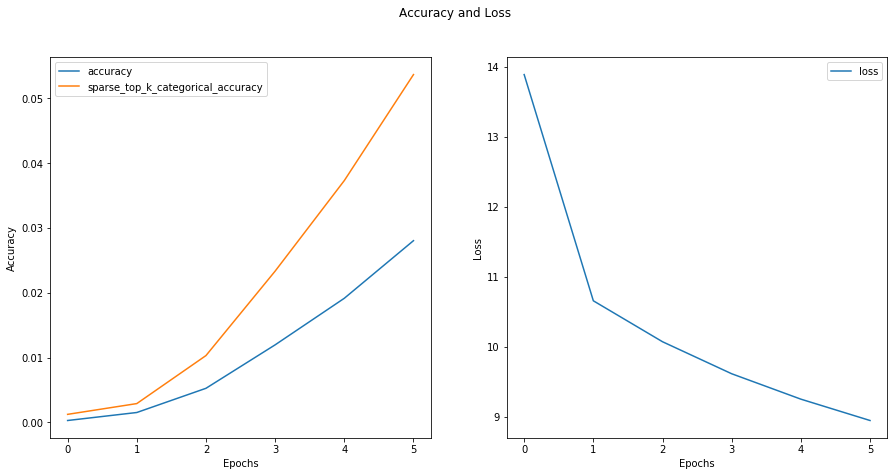

In [16]:
plot_accuracy_loss(image_hist,
                   ['accuracy','sparse_top_k_categorical_accuracy'],
                   ['loss'])

**Pickle the history and save the model**

In [ ]:
save_path = # path to stuff, end with a slash /

image_hist.save(save_path + "inception_image_model")
pickle.dump(image_hist, save_path + "inception_model_history")